In [1]:
from datetime import datetime, timedelta
import intake

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

import metpy.calc as mpcalc

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

import xarray as xr

cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/catalog.yaml")


# --- define specific heats of interest
cp = 1004   # J / kg K
Lv = 2.5e6  # J / kg
g  = 9.81   # m/s2  

In [2]:
## --- I downloaded the Level 2 version of EUREC4A profiles
level2_path = "/work/mh1498/m301248/TCO_data/eurec4a_profiles_level2/EUREC4A_BCO_Vaisala-RS_L2_v3.0.0.nc"


ds_eureca = xr.open_dataset(level2_path)
ds_eureca = ds_eureca.where(((ds_eureca["platform"] == 1)&(ds_eureca["ascent_flag"]==1)), drop=True)

In [3]:
ds_orcestra = xr.open_dataset("ipfs://bafybeid7cnw62zmzfgxcvc6q6fa267a7ivk2wcchbmkoyk4kdi5z2yj2w4", engine="zarr")
ds_orcestra
ds_orcestra_bco = ds_orcestra.where(((ds_orcestra["platform"] == "BCO")&(ds_orcestra["ascent_flag"]==0)), drop=True)


In [4]:
# mask = (ds_orcestra.launch_lon <= ds_eureca.lon.values+1) & (ds_orcestra.launch_lon >= ds_eureca.lon.values-1) & (ds_orcestra.launch_lat <= ds_eureca.lat.values+1) & (ds_orcestra.launch_lat >= ds_eureca.lat.values-1)
BCO_lon = -59.4288
BCO_lat = 13.1627

# mask = (ds_orcestra.launch_lon <= BCO_lon+0.5) & (ds_orcestra.launch_lon >= BCO_lon-0.5) & (ds_orcestra.launch_lat <= BCO_lat+0.5) & (ds_orcestra.launch_lat >= BCO_lat-0.5)

# ds_orcestra_bco = ds_orcestra.where(mask, drop=True)


In [ ]:
ascending_times = ds_orcestra_bco.launch_time.where(ds_orcestra_bco.ascent_flag == 0, drop=True)
descending_times = ds_orcestra_bco.launch_time.where(ds_orcestra_bco.ascent_flag == 1, drop=True)

/tmp/ipykernel_2209217/2915271232.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_height = ds_orcestra_bco.dims['height']


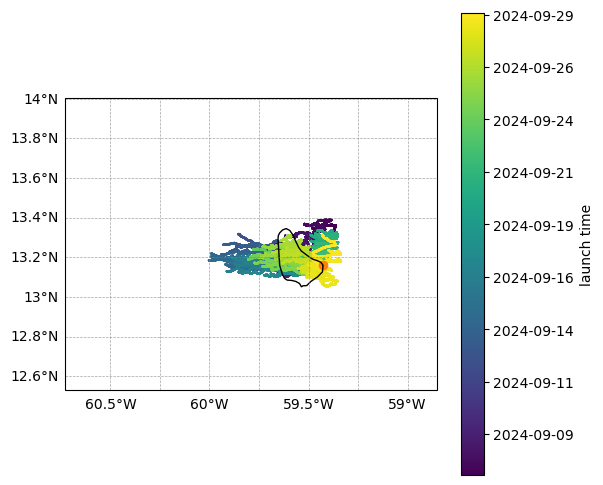

In [59]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(
    figsize=(6, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

time_num = mdates.date2num(ds_orcestra_bco['launch_time'].sel(launch_time=ascending_times).values)
n_height = ds_orcestra_bco.dims['height']
cvals = np.repeat(time_num, n_height)

pos = ax.scatter(ds_orcestra_bco['lon'].sel(launch_time=ascending_times).values.ravel(),
                 ds_orcestra_bco['lat'].sel(launch_time=ascending_times).values.ravel(), 
                 c=cvals, transform=ccrs.PlateCarree(), s=0.5
                 )

cbar = plt.colorbar(pos, ax=ax, label="launch time")
cbar.ax.yaxis.set_major_formatter(
    mdates.DateFormatter('%Y-%m-%d')
)


ax.scatter(BCO_lon, BCO_lat, transform=ccrs.PlateCarree(), c="tab:orange")

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

ax.set_extent([
    ds_orcestra_bco.launch_lon.min() - 0.5,
    ds_orcestra_bco.launch_lon.max() + 0.5,
    ds_orcestra_bco.launch_lat.min() - 0.5,
    ds_orcestra_bco.launch_lat.max() + 0.5
], crs=ccrs.PlateCarree())


gl = ax.gridlines(
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.7,
    linestyle='--'
)

gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

plt.show()


### descending RS are also included here!

In [54]:
print(f"{(ds_orcestra_bco.ascent_flag.sum(dim="launch_time") *100 / ds_orcestra_bco.launch_time.shape[0]).values:.2f} % of RS are descending")


48.91 % of RS are descending


In [5]:
mse_orc = cp*ds_orcestra_bco["ta"] + Lv*ds_orcestra_bco["mr"] + g*ds_orcestra_bco["mr"].height                                #ds_orcestra_bco.height
mse_sat_orc = cp*ds_orcestra_bco["ta"] + Lv*ds_orcestra_bco["mr"]/ds_orcestra_bco["rh"] + g*ds_orcestra_bco["mr"].height      #ds_orcestra_bco.height


(25000.0, 30000.0)

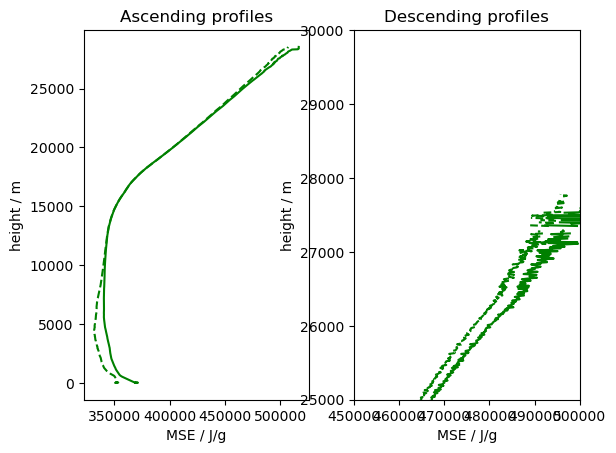

In [41]:
fig, ax = plt.subplots(1,2)




ax[0].plot(mse_orc.sel(launch_time=ascending_times).mean(dim="launch_time"), mse_orc.sel(launch_time=ascending_times).height, "g--")
ax[0].plot(mse_sat_orc.sel(launch_time=ascending_times).mean(dim="launch_time"), mse_orc.sel(launch_time=ascending_times).height, "g-")
ax[0].set_title("Ascending profiles")
ax[0].set_xlabel("MSE / J/g")
ax[0].set_ylabel("height / m")

ax[1].plot(mse_orc.sel(launch_time=descending_times).mean(dim="launch_time"), mse_orc.sel(launch_time=descending_times).height, "g--")
ax[1].plot(mse_sat_orc.sel(launch_time=descending_times).mean(dim="launch_time"), mse_orc.sel(launch_time=descending_times).height, "g-")
ax[1].set_title("Descending profiles")
ax[1].set_xlabel("MSE / J/g")
ax[1].set_ylabel("height / m")
# ax[1].set_xlim(450e3, 500e3)
# ax[1].set_ylim(25e3, 30e3)

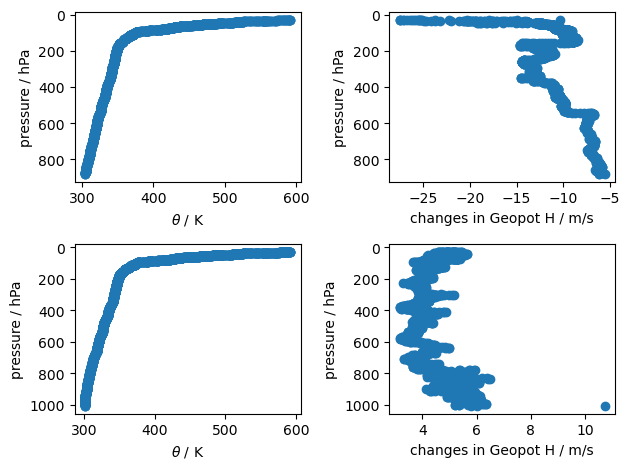

In [57]:
fig, ax = plt.subplots(2,2)
ax = ax.flatten()
d = int(20)


ax[0].scatter(ds_orcestra_bco.sel(launch_time=descending_times)["theta"][d], ds_orcestra_bco.sel(launch_time=descending_times)["p"][d]/100)
ax[0].invert_yaxis()
ax[0].set_xlabel(r"$\theta$ / K")

ax[1].scatter(ds_orcestra_bco.sel(launch_time=descending_times)["dz"][d], ds_orcestra_bco.sel(launch_time=descending_times)["p"][d]/100)
ax[1].invert_yaxis()
ax[1].set_xlabel("changes in Geopot H / m/s")



ax[2].scatter(ds_orcestra_bco.sel(launch_time=ascending_times)["theta"][d], ds_orcestra_bco.sel(launch_time=ascending_times)["p"][d]/100)
ax[2].invert_yaxis()
ax[2].set_xlabel(r"$\theta$ / K")

ax[3].scatter(ds_orcestra_bco.sel(launch_time=ascending_times)["dz"][d], ds_orcestra_bco.sel(launch_time=ascending_times)["p"][d]/100)
ax[3].invert_yaxis()
ax[3].set_xlabel("changes in Geopot H / m/s")

for x in ax:
    x.set_ylabel("pressure / hPa")

plt.tight_layout()

In [5]:
mse_eu  = cp*ds_eureca["ta"] + Lv*ds_eureca["mr"] + g*ds_eureca.alt
mse_orc = cp*ds_orcestra_bco["ta"] + Lv*ds_orcestra_bco["mr"] + g*ds_orcestra_bco.height

mse_sat_eu  = cp*ds_eureca["ta"] + Lv*ds_eureca["mr"]/ds_eureca["rh"] + g*ds_eureca.alt
mse_sat_orc = cp*ds_orcestra_bco["ta"] + Lv*ds_orcestra_bco["mr"]/ds_orcestra_bco["rh"] + g*ds_orcestra_bco.height

## --- MSE
mse_eu_mean =  mse_eu.mean(dim="sounding")
mse_orc_mean = mse_orc.mean(dim="launch_time")

mse_eu_std =  mse_eu.std(dim="sounding")
mse_orc_std = mse_orc.std(dim="launch_time")


## --- MSE sat
mse_sat_eu_mean =  mse_sat_eu.mean(dim="sounding")
mse_sat_orc_mean = mse_sat_orc.mean(dim="launch_time")

mse_sat_eu_std =  mse_sat_eu.std(dim="sounding")
mse_sat_orc_std = mse_sat_orc.std(dim="launch_time")

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: Run

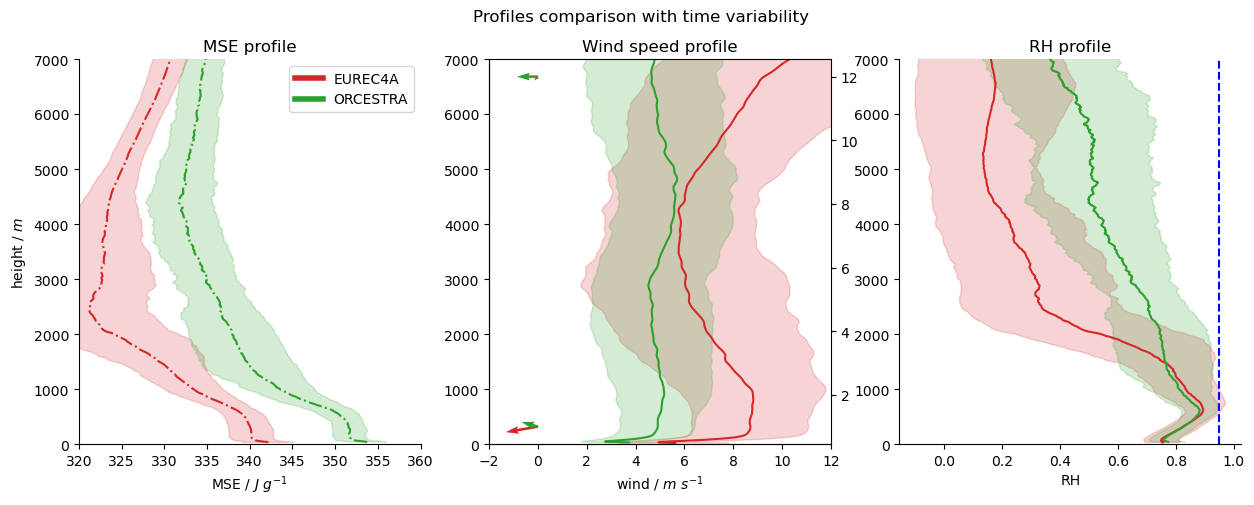

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Profiles comparison with time variability")
top_lim = 7000

# --- Plot mean MSE profile ---
ax[0].plot( mse_eu_mean/1e3,   mse_eu_mean.alt, linestyle='-.', color="tab:red", label="EUREC4A")
ax[0].plot( mse_orc_mean/1e3, mse_orc_mean.height, linestyle='-.', color="tab:green", label="ORCESTRA")

ax[0].fill_betweenx(
    mse_eu_mean.alt,
    (mse_eu_mean - mse_eu_std)/1e3 ,
    (mse_eu_mean + mse_eu_std)/1e3 ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax[0].fill_betweenx(
    mse_orc_mean.height,
    (mse_orc_mean - mse_orc_std)/1e3 ,
    (mse_orc_mean + mse_orc_std)/1e3 ,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)


## --- plot mean wind profiles in ax[1]
ax[1].plot(ds_eureca["wspd"].mean(dim="sounding"), ds_eureca.alt,  color="tab:red", label="EU")
ax[1].plot(ds_orcestra_bco["wspd"].mean(dim="launch_time"), ds_orcestra_bco.height, color="tab:green", label="OR")


ax[1].fill_betweenx(
    ds_eureca.alt,
    (ds_eureca["wspd"].mean(dim="sounding") - ds_eureca["wspd"].std(dim="sounding")) ,
    (ds_eureca["wspd"].mean(dim="sounding") + ds_eureca["wspd"].std(dim="sounding")) ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax[1].fill_betweenx(
    ds_orcestra_bco.height,
    (ds_orcestra_bco["wspd"].mean(dim="launch_time") - ds_orcestra_bco["wspd"].std(dim="launch_time")) ,
    (ds_orcestra_bco["wspd"].mean(dim="launch_time") + ds_orcestra_bco["wspd"].std(dim="launch_time")) ,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)


## - add few quivers for direction!!
# twin_ax1 = ax[1].twinx()
# twin_ax1.quiver(
#     [0., 0.],
#     [1, 12],
#     [ds_eureca["u"].mean(dim="sounding").sel(alt=300), ds_eureca["u"].mean(dim="sounding").sel(alt=5000)],
#     [ds_eureca["v"].mean(dim="sounding").sel(alt=300), ds_eureca["v"].mean(dim="sounding").sel(alt=5000)], 
#     color="tab:red", 
# )
# twin_ax1.quiver(
#     [0., 0.],
#     [1, 12],
#     [ds_orcestra_bco["u"].mean(dim="launch_time").sel(height=300), ds_orcestra_bco["u"].mean(dim="launch_time").sel(height=5000)],
#     [ds_orcestra_bco["v"].mean(dim="launch_time").sel(height=300), ds_orcestra_bco["v"].mean(dim="launch_time").sel(height=5000)], 
#     color="tab:green", 
# )




## --- where is it that RH is close to 1?
ax[2].plot(ds_eureca["rh"].mean(dim="sounding"), ds_eureca.alt, color="tab:red", label="EU")
ax[2].plot(ds_orcestra_bco["rh"].mean(dim="launch_time"), ds_orcestra_bco.height, color="tab:green", label="OR")

ax[2].fill_betweenx(
    ds_eureca.alt,
    (ds_eureca["rh"].mean(dim="sounding") - ds_eureca["rh"].std(dim="sounding")) ,
    (ds_eureca["rh"].mean(dim="sounding") + ds_eureca["rh"].std(dim="sounding")) ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax[2].fill_betweenx(
    ds_orcestra_bco.height,
    (ds_orcestra_bco["rh"].mean(dim="launch_time") - ds_orcestra_bco["rh"].std(dim="launch_time")) ,
    (ds_orcestra_bco["rh"].mean(dim="launch_time") + ds_orcestra_bco["rh"].std(dim="launch_time")) ,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)

ax[2].vlines(x=0.95, ymin=0, ymax=top_lim, linestyle="--", color="blue")



## --- axes properties
ax[0].set_xlabel(r"MSE / $J~g^{-1}$")
ax[0].set_ylabel(r"height / $m$")
ax[0].set_title("MSE profile")
ax[0].set_xlim(320,360)

ax[1].set_xlabel(r"wind / $m~s^{-1}$")
ax[1].set_title("Wind speed profile")
ax[1].set_xlim(-2,12)

ax[2].set_xlabel(r"RH")
ax[2].set_title("RH profile")


## --- legend
legend_elements = [
    Line2D([0], [0], color='tab:red', lw=4, label='EUREC4A'),
    Line2D([0], [0], color='tab:green', lw=4, label='ORCESTRA')
]
ax[0].legend(handles=legend_elements, loc='best')


for x in ax:
    x.set_ylim(0,top_lim)
    for spine in ['top', 'right']:
        x.spines[spine].set_visible(False)


Text(0.5, 1.0, 'ORCESTRA')

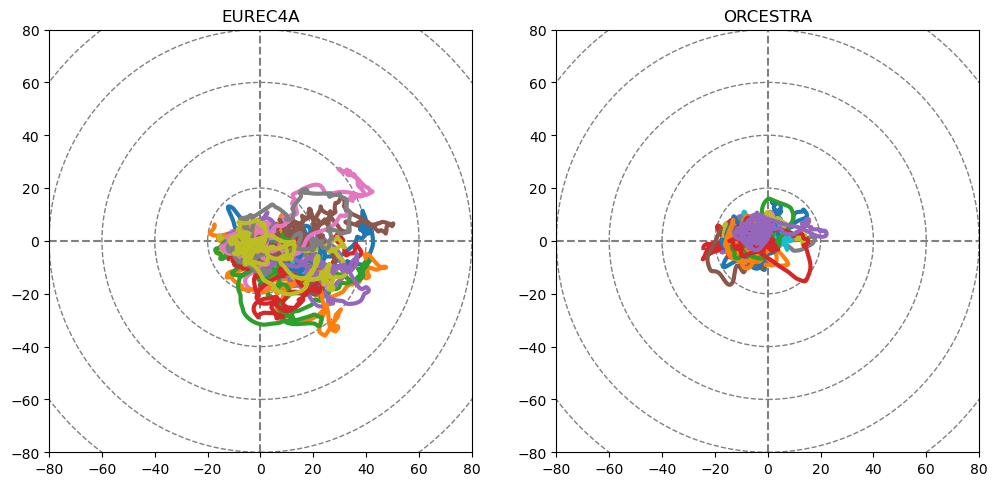

In [29]:
from metpy.plots import Hodograph

fig, ax = plt.subplots(1,2,figsize=(12,12))

h0 = Hodograph(ax[0], component_range=80.)  # create instance
h0.add_grid(increment=20)

h1 = Hodograph(ax[1], component_range=80.)  # create instance
h1.add_grid(increment=20)

for i in range(0,ds_eureca.launch_time.size,10):
    u = ds_eureca["u"].isel(sounding=i).values
    v = ds_eureca["v"].isel(sounding=i).values
    h0.plot(u, v)
ax[0].set_title("EUREC4A")


for i in range(0, ds_orcestra_bco.launch_time.size, 10):
    u = ds_orcestra_bco["u"].isel(launch_time=i).values
    v = ds_orcestra_bco["v"].isel(launch_time=i).values
    h1.plot(u, v)
ax[1].set_title("ORCESTRA")



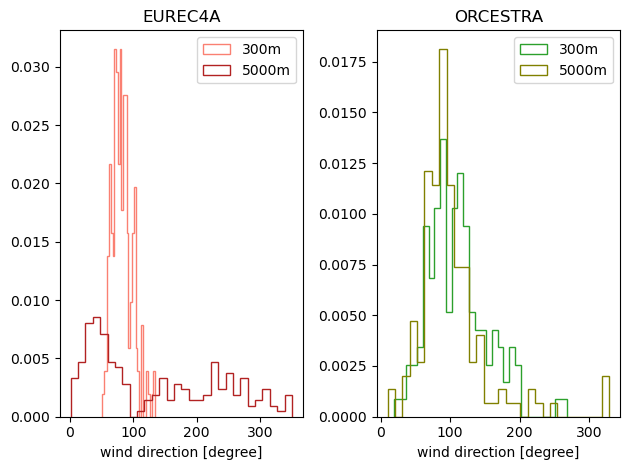

In [25]:
fig, ax = plt.subplots(1, 2)

ds_eureca["wdir"].sel(alt=300).plot.hist(ax=ax[0], bins=30,  color="salmon" , label="300m" , histtype="step", density=True)
ds_eureca["wdir"].sel(alt=5000).plot.hist(ax=ax[0], bins=30, color="firebrick" , label="5000m" , histtype="step", density=True)
ax[0].set_title("EUREC4A")
ax[0].legend()

ds_orcestra_bco["wdir"].sel(height=300).plot.hist(ax=ax[1], bins=30, color="tab:green",  label="300m" ,  histtype="step", density=True)
ds_orcestra_bco["wdir"].sel(height=5000).plot.hist(ax=ax[1], bins=30, color="olive", label="5000m" , histtype="step", density=True)
ax[1].set_title("ORCESTRA")
ax[1].legend()

plt.tight_layout()

In [6]:
## add mean LCL to plot
cbh_eu_ds = xr.open_dataset("/work/mh1498/m301248/TCO_data/cbh_data/EU_cbh_lcl_windowed_quantiles.nc")
lcl_eu =  cbh_eu_ds.lcl_quantiles.isel(quantile_lcl=0).mean(dim="launch_time")
cbh_eu =  cbh_eu_ds.cbh_quantiles.isel(quantile=0).mean(dim="launch_time")

cbh_or_ds = xr.open_dataset("/work/mh1498/m301248/TCO_data/cbh_data/OR_cbh_lcl_windowed_quantiles.nc")
lcl_or = cbh_or_ds.lcl_quantiles.isel(quantile_lcl=0).mean(dim="launch_time")
cbh_or = cbh_or_ds.cbh_quantiles.isel(quantile=0).mean(dim="launch_time")

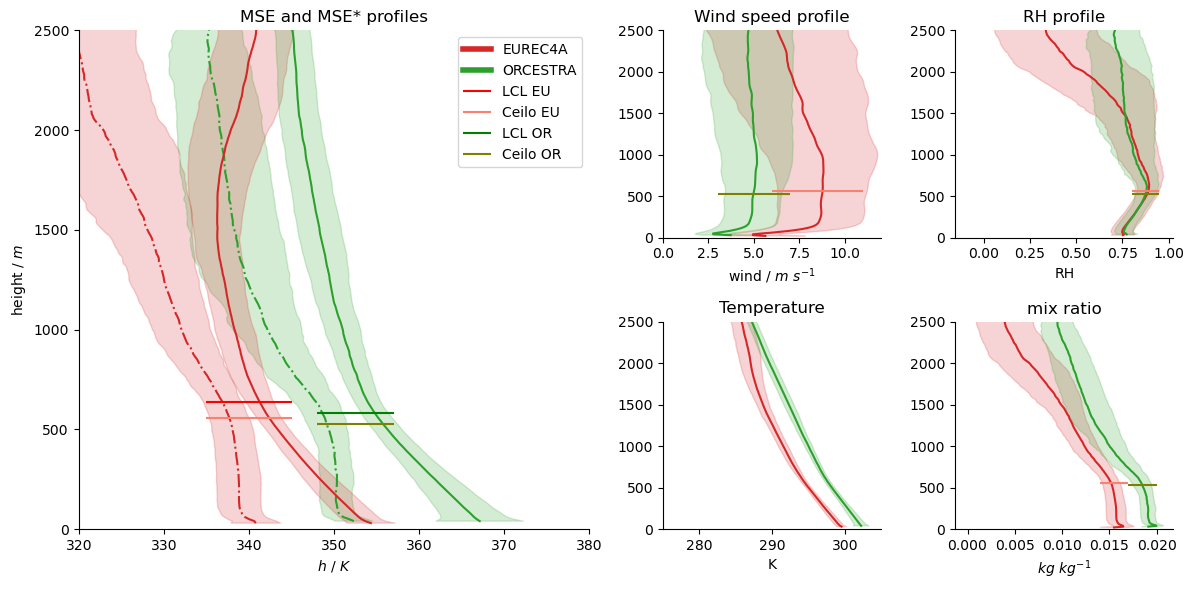

In [25]:
import matplotlib.gridspec as gridspec


import warnings
warnings.filterwarnings("ignore")



fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 4)  # 1 row, 4 columns
top_lim = 2500

# Large subplot spanning columns 0 and 1
ax_big = fig.add_subplot(gs[:, 0:2])  # Spans columns 0 and 1 in row 0

# - mse plots
ax_big.plot( mse_eu_mean/cp,   mse_eu_mean.alt, linestyle='-.', color="tab:red", label="EUREC4A")
ax_big.plot( mse_orc_mean/cp, mse_orc_mean.height, linestyle='-.', color="tab:green", label="ORCESTRA")

ax_big.fill_betweenx(
    mse_eu_mean.alt,
    (mse_eu_mean - mse_eu_std)/cp ,
    (mse_eu_mean + mse_eu_std)/cp ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax_big.fill_betweenx(
    mse_orc_mean.height,
    (mse_orc_mean - mse_orc_std)/cp ,
    (mse_orc_mean + mse_orc_std)/cp ,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)

## - saturated mse plots
ax_big.plot( mse_sat_eu_mean/cp,   mse_sat_eu_mean.alt, linestyle='-', color="tab:red", label="EUREC4A")
ax_big.plot( mse_sat_orc_mean/cp, mse_sat_orc_mean.height, linestyle='-', color="tab:green", label="ORCESTRA")

ax_big.fill_betweenx(
    mse_sat_eu_mean.alt,
    (mse_sat_eu_mean - mse_sat_eu_std)/cp ,
    (mse_sat_eu_mean + mse_sat_eu_std)/cp ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax_big.fill_betweenx(
    mse_sat_orc_mean.height,
    (mse_sat_orc_mean - mse_sat_orc_std)/cp ,
    (mse_sat_orc_mean + mse_sat_orc_std)/cp ,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)



## add cbh info - cbh_eu
l1 = ax_big.hlines(lcl_eu, xmin=335, xmax=345, color="red", label="LCL EU")
l2 = ax_big.hlines(cbh_eu, xmin=335, xmax=345, color="salmon", label="Ceilo EU")

l3 = ax_big.hlines(lcl_or, xmin=348, xmax=357, color="green", label="LCL OR")
l4 = ax_big.hlines(cbh_or, xmin=348, xmax=357, color="olive", label="Ceilo OR")


# - axis properties
ax_big.set_xlabel(r"$h$ / $K$")
ax_big.set_ylabel(r"height / $m$")
ax_big.set_title("MSE and MSE* profiles")
ax_big.set_xlim(320,380)




## - wspd 
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Subplot 3")
ax3.plot(ds_eureca["wspd"].mean(dim="sounding"), ds_eureca.alt,  color="tab:red", label="EU")
ax3.plot(ds_orcestra_bco["wspd"].mean(dim="launch_time"), ds_orcestra_bco.height, color="tab:green", label="OR")


ax3.fill_betweenx(
    ds_eureca.alt,
    (ds_eureca["wspd"].mean(dim="sounding") - ds_eureca["wspd"].std(dim="sounding")) ,
    (ds_eureca["wspd"].mean(dim="sounding") + ds_eureca["wspd"].std(dim="sounding")) ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax3.fill_betweenx(
    ds_orcestra_bco.height,
    (ds_orcestra_bco["wspd"].mean(dim="launch_time") - ds_orcestra_bco["wspd"].std(dim="launch_time")) ,
    (ds_orcestra_bco["wspd"].mean(dim="launch_time") + ds_orcestra_bco["wspd"].std(dim="launch_time")) ,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)


ax3.hlines(cbh_eu, xmin=6, xmax=11, color="salmon", label="Ceilo EU")
ax3.hlines(cbh_or, xmin=3, xmax=7, color="olive", label="Ceilo OR")

ax3.set_xlabel(r"wind / $m~s^{-1}$")
ax3.set_title("Wind speed profile")
ax3.set_xlim(0,12)



# RH
ax4 = fig.add_subplot(gs[0, 3])
ax4.set_title("Subplot 4")
ax4.plot(ds_eureca["rh"].mean(dim="sounding"), ds_eureca.alt, color="tab:red", label="EU")
ax4.plot(ds_orcestra_bco["rh"].mean(dim="launch_time"), ds_orcestra_bco.height, color="tab:green", label="OR")

ax4.fill_betweenx(
    ds_eureca.alt,
    (ds_eureca["rh"].mean(dim="sounding") - ds_eureca["rh"].std(dim="sounding")) ,
    (ds_eureca["rh"].mean(dim="sounding") + ds_eureca["rh"].std(dim="sounding")) ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax4.fill_betweenx(
    ds_orcestra_bco.height,
    (ds_orcestra_bco["rh"].mean(dim="launch_time") - ds_orcestra_bco["rh"].std(dim="launch_time")) ,
    (ds_orcestra_bco["rh"].mean(dim="launch_time") + ds_orcestra_bco["rh"].std(dim="launch_time")) ,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)

ax4.hlines(cbh_eu, xmin=0.8, xmax=0.95, color="salmon", label="Ceilo EU")
ax4.hlines(cbh_or, xmin=0.8, xmax=0.95, color="olive", label="Ceilo OR")

ax4.set_xlabel(r"RH")
ax4.set_title("RH profile")






# Temperature
ax5 = fig.add_subplot(gs[1, 2])
ax5.plot(ds_eureca["ta"].mean(dim="sounding"), ds_eureca.alt, color="tab:red", label="EU")
ax5.plot(ds_orcestra_bco["ta"].mean(dim="launch_time"), ds_orcestra_bco.height, color="tab:green", label="OR")

ax5.fill_betweenx(
    ds_eureca.alt,
    (ds_eureca["ta"].mean(dim="sounding") - ds_eureca["ta"].std(dim="sounding")) ,
    (ds_eureca["ta"].mean(dim="sounding") + ds_eureca["ta"].std(dim="sounding")) ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax5.fill_betweenx(
    ds_orcestra_bco.height,
    (ds_orcestra_bco["ta"].mean(dim="launch_time") - ds_orcestra_bco["ta"].std(dim="launch_time")) ,
    (ds_orcestra_bco["ta"].mean(dim="launch_time") + ds_orcestra_bco["ta"].std(dim="launch_time")) ,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)

ax5.set_xlabel(r"K")
ax5.set_title("Temperature")
ax5.set_xlim(275,305)


# moisture
ax6 = fig.add_subplot(gs[1, 3])
ax6.plot(ds_eureca["mr"].mean(dim="sounding"), ds_eureca.alt, color="tab:red", label="EU")
ax6.plot(ds_orcestra_bco["mr"].mean(dim="launch_time"), ds_orcestra_bco.height, color="tab:green", label="OR")

ax6.fill_betweenx(
    ds_eureca.alt,
    (ds_eureca["mr"].mean(dim="sounding") - ds_eureca["mr"].std(dim="sounding")) ,
    (ds_eureca["mr"].mean(dim="sounding") + ds_eureca["mr"].std(dim="sounding")) ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax6.fill_betweenx(
    ds_orcestra_bco.height,
    (ds_orcestra_bco["mr"].mean(dim="launch_time") - ds_orcestra_bco["mr"].std(dim="launch_time")) ,
    (ds_orcestra_bco["mr"].mean(dim="launch_time") + ds_orcestra_bco["mr"].std(dim="launch_time")) ,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)


ax6.hlines(cbh_eu, xmin=14e-3, xmax=17e-3, color="salmon", label="Ceilo EU")
ax6.hlines(cbh_or, xmin=17e-3, xmax=20e-3, color="olive", label="Ceilo OR")

ax6.set_xlabel(r"$kg~kg^{-1}$")
ax6.set_title("mix ratio")






## - esthetics

legend_elements = [
    Line2D([0], [0], color='tab:red', lw=4, label='EUREC4A'),
    Line2D([0], [0], color='tab:green', lw=4, label='ORCESTRA'), 
    l1, l2, l3, l4
]
ax_big.legend(handles=legend_elements, loc='best')

axes = []
axes.append(ax_big)
axes.append(ax3)
axes.append(ax4)
axes.append(ax5)
axes.append(ax6)
for x in axes:
    x.set_ylim(0,top_lim)
    # x.hlines(y=600, xmin=x.get_xlim()[0], xmax=x.get_xlim()[1])
    for spine in ['top', 'right']:
        x.spines[spine].set_visible(False)


plt.tight_layout()
plt.show()


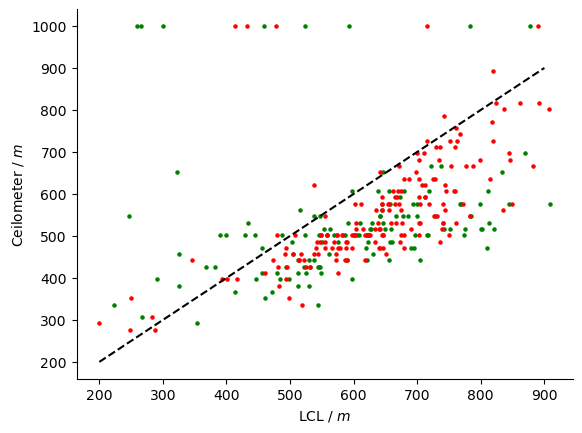

In [24]:
plt.scatter(cbh_or_ds.lcl_quantiles.isel(quantile_lcl=0), cbh_or_ds.cbh_quantiles.isel(quantile=0), color="green", s=5)
plt.scatter(cbh_eu_ds.lcl_quantiles.isel(quantile_lcl=0), cbh_eu_ds.cbh_quantiles.isel(quantile=0), color="red", s=5)

plt.plot([200, 900], [200, 900], "k--")

plt.ylabel("Ceilometer / $m$")
plt.xlabel("LCL / $m$")

for spine in ['top', 'right']:
        plt.gca().spines[spine].set_visible(False)


/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: Run

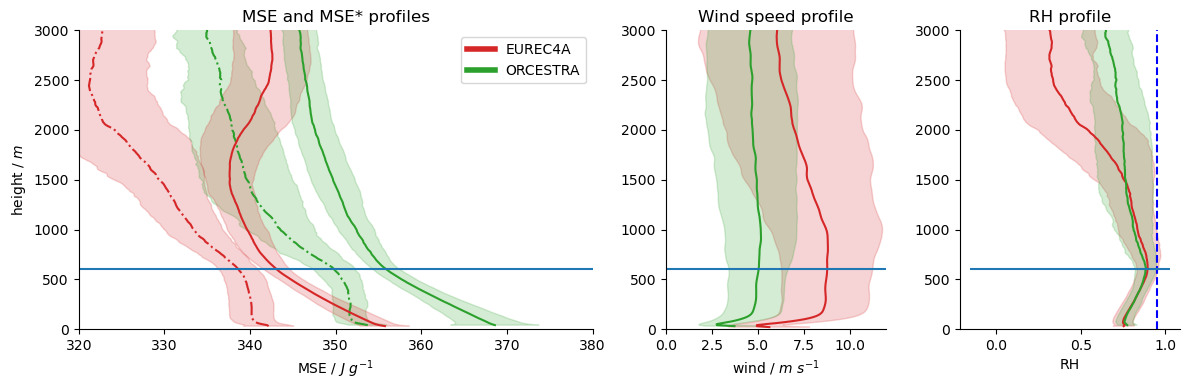

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 4)  # 1 row, 4 columns
top_lim = 3000

# Large subplot spanning columns 0 and 1
ax_big = fig.add_subplot(gs[0, 0:2])

# - mse plots
ax_big.plot( mse_eu_mean/cp,   mse_eu_mean.alt, linestyle='-.', color="tab:red", label="EUREC4A")
ax_big.plot( mse_orc_mean/cp, mse_orc_mean.height, linestyle='-.', color="tab:green", label="ORCESTRA")

ax_big.fill_betweenx(
    mse_eu_mean.alt,
    (mse_eu_mean - mse_eu_std)/cp ,
    (mse_eu_mean + mse_eu_std)/cp ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax_big.fill_betweenx(
    mse_orc_mean.height,
    (mse_orc_mean - mse_orc_std)/cp ,
    (mse_orc_mean + mse_orc_std)/cp ,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)

## - saturated mse plots
ax_big.plot( mse_sat_eu_mean/cp,   mse_sat_eu_mean.alt, linestyle='-', color="tab:red", label="EUREC4A")
ax_big.plot( mse_sat_orc_mean/cp, mse_sat_orc_mean.height, linestyle='-', color="tab:green", label="ORCESTRA")

ax_big.fill_betweenx(
    mse_sat_eu_mean.alt,
    (mse_sat_eu_mean - mse_sat_eu_std)/cp ,
    (mse_sat_eu_mean + mse_sat_eu_std)/cp ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax_big.fill_betweenx(
    mse_sat_orc_mean.height,
    (mse_sat_orc_mean - mse_sat_orc_std)/cp ,
    (mse_sat_orc_mean + mse_sat_orc_std)/cp ,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)

# - axis properties
ax_big.set_xlabel(r"$h$ / $K$")
ax_big.set_ylabel(r"height / $m$")
ax_big.set_title("MSE and MSE* profiles")
ax_big.set_xlim(320,380)




## - wspd 
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Subplot 3")
ax3.plot(ds_eureca["wspd"].mean(dim="sounding"), ds_eureca.alt,  color="tab:red", label="EU")
ax3.plot(ds_orcestra_bco["wspd"].mean(dim="launch_time"), ds_orcestra_bco.height, color="tab:green", label="OR")


ax3.fill_betweenx(
    ds_eureca.alt,
    (ds_eureca["wspd"].mean(dim="sounding") - ds_eureca["wspd"].std(dim="sounding")) ,
    (ds_eureca["wspd"].mean(dim="sounding") + ds_eureca["wspd"].std(dim="sounding")) ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax3.fill_betweenx(
    ds_orcestra_bco.height,
    (ds_orcestra_bco["wspd"].mean(dim="launch_time") - ds_orcestra_bco["wspd"].std(dim="launch_time")) ,
    (ds_orcestra_bco["wspd"].mean(dim="launch_time") + ds_orcestra_bco["wspd"].std(dim="launch_time")) ,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)

ax3.set_xlabel(r"wind / $m~s^{-1}$")
ax3.set_title("Wind speed profile")
ax3.set_xlim(0,12)



# Normal subplot in column 3
ax4 = fig.add_subplot(gs[0, 3])
ax4.set_title("Subplot 4")
ax4.plot(ds_eureca["rh"].mean(dim="sounding"), ds_eureca.alt, color="tab:red", label="EU")
ax4.plot(ds_orcestra_bco["rh"].mean(dim="launch_time"), ds_orcestra_bco.height, color="tab:green", label="OR")

ax4.fill_betweenx(
    ds_eureca.alt,
    (ds_eureca["rh"].mean(dim="sounding") - ds_eureca["rh"].std(dim="sounding")) ,
    (ds_eureca["rh"].mean(dim="sounding") + ds_eureca["rh"].std(dim="sounding")) ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax4.fill_betweenx(
    ds_orcestra_bco.height,
    (ds_orcestra_bco["rh"].mean(dim="launch_time") - ds_orcestra_bco["rh"].std(dim="launch_time")) ,
    (ds_orcestra_bco["rh"].mean(dim="launch_time") + ds_orcestra_bco["rh"].std(dim="launch_time")) ,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)

ax4.vlines(x=0.95, ymin=0, ymax=top_lim, linestyle="--", color="blue")

ax4.set_xlabel(r"RH")
ax4.set_title("RH profile")



## - esthetics

legend_elements = [
    Line2D([0], [0], color='tab:red', lw=4, label='EUREC4A'),
    Line2D([0], [0], color='tab:green', lw=4, label='ORCESTRA')
]
ax_big.legend(handles=legend_elements, loc='best')

axes = []
axes.append(ax_big)
axes.append(ax3)
axes.append(ax4)
for x in axes:
    x.set_ylim(0,top_lim)
    x.hlines(y=600, xmin=x.get_xlim()[0], xmax=x.get_xlim()[1])
    for spine in ['top', 'right']:
        x.spines[spine].set_visible(False)


plt.tight_layout()
plt.show()


In [20]:
path_to_ceilo_eureca = "/work/pd1327/OBS/BARBADOS_CLOUD_OBSERVATORY/Level_1/A_Cloud_base_heights/CEILO__CHM15k_MPI__CBH__10s__EUREC4A.nc"
ceilo_eureca = xr.open_dataset(path_to_ceilo_eureca)
ceilo_eureca['time'] = ceilo_eureca['time'].astype('datetime64[ns]')
ceilo_eureca = ceilo_eureca.sortby('time')


path_to_ceilo_orcestra = ["/work/pd1327/OBS/BARBADOS_CLOUD_OBSERVATORY/Level_1/A_Cloud_base_heights/CEILO__CHM15k_MPI__CBH__10s__202408.nc",\
                          "/work/pd1327/OBS/BARBADOS_CLOUD_OBSERVATORY/Level_1/A_Cloud_base_heights/CEILO__CHM15k_MPI__CBH__10s__202409.nc"]

ceilo_orcestra = xr.open_mfdataset(path_to_ceilo_orcestra)
ceilo_orcestra['time'] = ceilo_orcestra['time'].astype('datetime64[ns]')
ceilo_orcestra = ceilo_orcestra.sortby('time')

/tmp/ipykernel_633764/1118727839.py:10: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ceilo_orcestra = xr.open_mfdataset(path_to_ceilo_orcestra)


/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: Run

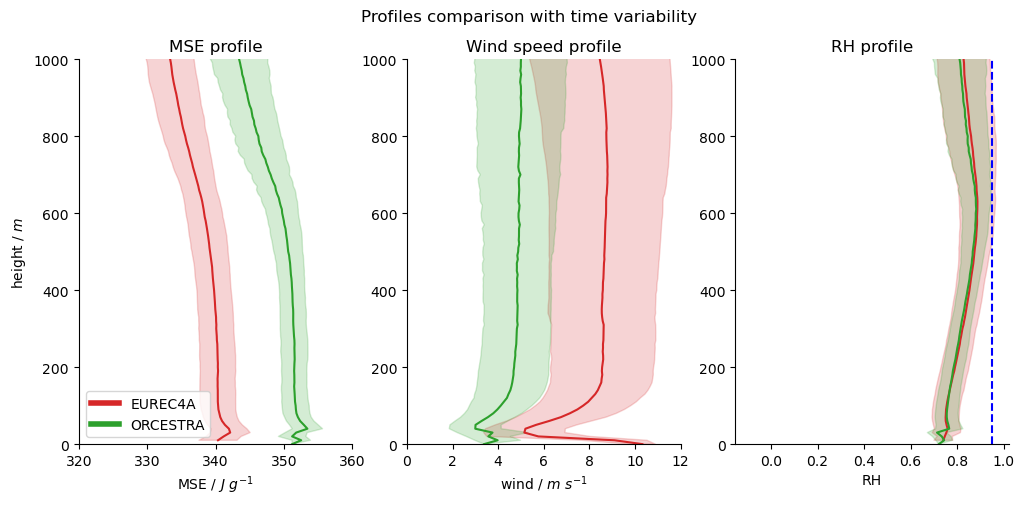

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Profiles comparison with time variability")
top_lim = 1000

# --- Plot mean MSE profile ---
ax[0].plot( mse_eu_mean/1e3,   mse_eu_mean.alt, linestyle='-', color="tab:red", label="EUREC4A")
ax[0].plot( mse_orc_mean/1e3, mse_orc_mean.height, linestyle='-', color="tab:green", label="ORCESTRA")

ax[0].fill_betweenx(
    mse_eu_mean.alt,
    (mse_eu_mean - mse_eu_std)/1e3 ,
    (mse_eu_mean + mse_eu_std)/1e3 ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax[0].fill_betweenx(
    mse_orc_mean.height,
    (mse_orc_mean - mse_orc_std)/1e3 ,
    (mse_orc_mean + mse_orc_std)/1e3 ,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)

# ax[0].hlines(y=ceilo_eureca["cbh_1"].mean(dim="time").values, xmin=325, xmax=335, color="tab:red", linestyle="dotted" )
# ax[0].hlines(y=ceilo_orcestra["cbh_1"].mean(dim="time").values, xmin=335, xmax=345, color="k", linestyle="dotted" )


## --- plot mean wind profiles in ax[1]
# ax[1].plot(ds_eureca["u"].mean(dim="sounding"), ds_eureca.alt, color="tab:red", label="EU u")
# ax[1].plot(ds_orcestra_bco["u"].mean(dim="launch_time"), ds_orcestra_bco.height, color="tab:green", label="OR u")

# ax[1].plot(ds_eureca["v"].mean(dim="sounding"), ds_eureca.alt, linestyle="--", color="tab:red", label="EU v")
# ax[1].plot(ds_orcestra_bco["v"].mean(dim="launch_time"), ds_orcestra_bco.height, linestyle="--", color="tab:green", label="OR v")


ax[1].plot(ds_eureca["wspd"].mean(dim="sounding"), ds_eureca.alt,  color="tab:red", label="EU")
ax[1].plot(ds_orcestra_bco["wspd"].mean(dim="launch_time"), ds_orcestra_bco.height, color="tab:green", label="OR")


ax[1].fill_betweenx(
    ds_eureca.alt,
    (ds_eureca["wspd"].mean(dim="sounding") - ds_eureca["wspd"].std(dim="sounding")) ,
    (ds_eureca["wspd"].mean(dim="sounding") + ds_eureca["wspd"].std(dim="sounding")) ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax[1].fill_betweenx(
    ds_orcestra_bco.height,
    (ds_orcestra_bco["wspd"].mean(dim="launch_time") - ds_orcestra_bco["wspd"].std(dim="launch_time")) ,
    (ds_orcestra_bco["wspd"].mean(dim="launch_time") + ds_orcestra_bco["wspd"].std(dim="launch_time")) ,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)




## --- where is it that RH is close to 1?
ax[2].plot(ds_eureca["rh"].mean(dim="sounding"), ds_eureca.alt, color="tab:red", label="EU")
ax[2].plot(ds_orcestra_bco["rh"].mean(dim="launch_time"), ds_orcestra_bco.height, color="tab:green", label="OR")

ax[2].fill_betweenx(
    ds_eureca.alt,
    (ds_eureca["rh"].mean(dim="sounding") - ds_eureca["rh"].std(dim="sounding")) ,
    (ds_eureca["rh"].mean(dim="sounding") + ds_eureca["rh"].std(dim="sounding")) ,
    color="tab:red",
    alpha=0.2,
    label='±1 std (time)'
)

ax[2].fill_betweenx(
    ds_orcestra_bco.height,
    (ds_orcestra_bco["rh"].mean(dim="launch_time") - ds_orcestra_bco["rh"].std(dim="launch_time")) ,
    (ds_orcestra_bco["rh"].mean(dim="launch_time") + ds_orcestra_bco["rh"].std(dim="launch_time")) ,
    color="tab:green",
    alpha=0.2,
    label='±1 std (time)'
)

ax[2].vlines(x=0.95, ymin=0, ymax=top_lim, linestyle="--", color="blue")



## --- axes properties
ax[0].set_xlabel(r"MSE / $J~g^{-1}$")
ax[0].set_ylabel(r"height / $m$")
ax[0].set_title("MSE profile")
ax[0].set_xlim(320,360)

ax[1].set_xlabel(r"wind / $m~s^{-1}$")
ax[1].set_title("Wind speed profile")
ax[1].set_xlim(0,12)

ax[2].set_xlabel(r"RH")
ax[2].set_title("RH profile")


## --- legend
legend_elements = [
    Line2D([0], [0], color='tab:red', lw=4, label='EUREC4A'),
    Line2D([0], [0], color='tab:green', lw=4, label='ORCESTRA')
]
ax[0].legend(handles=legend_elements, loc='best')


for x in ax:
    x.set_ylim(0,top_lim)
    for spine in ['top', 'right']:
        x.spines[spine].set_visible(False)


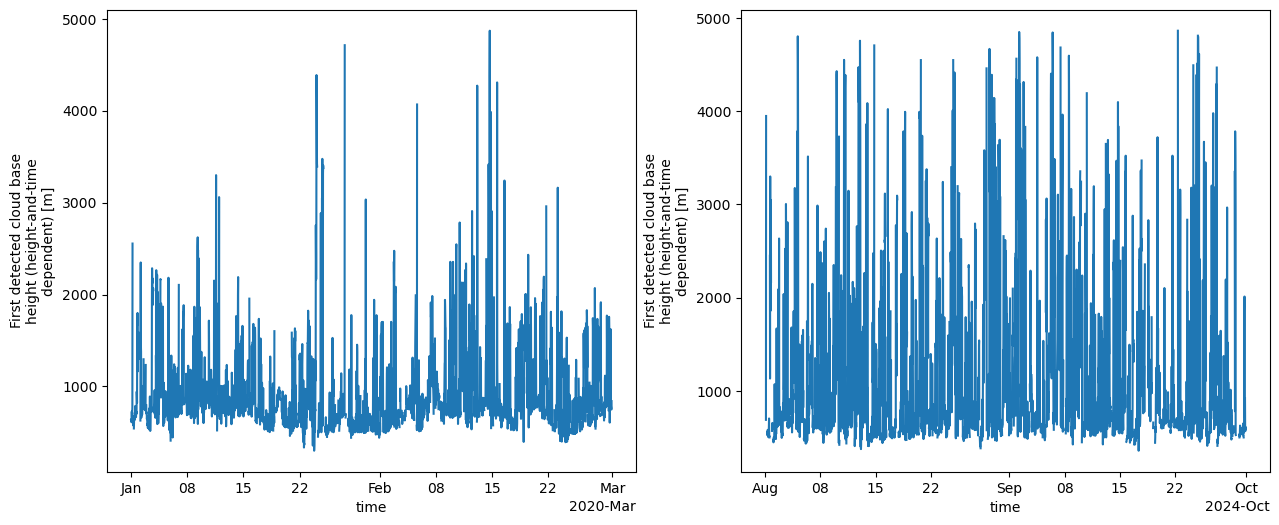

In [28]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ceilo_eureca["cbh_1"].resample(time="30min").mean().plot(ax=ax[0], x="time")

ceilo_orcestra["cbh_1"].resample(time="30min").mean().plot(ax=ax[1], x="time")

In [ ]:
## CORAL radar data not on the catalogue
## m301248@login1:/pool/OBS/BARBADOS_CLOUD_OBSERVATORY/Level_1/B_Reflectivity/Ka-Band/MBR2/2s$ 

coral_radar = cat.BCO.radar_MBR2_c4_v1.to_dask()
coral_radar

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 2TB
Dimensions:     (time: 62718216, alt: 605)
Coordinates:
  * time        (time) datetime64[ns] 502MB 2018-04-30T00:00:17 ... 2023-03-1...
  * alt         (alt) float64 5kB 174.4 205.6 236.8 ... 1.898e+04 1.901e+04
    lat         float64 8B ...
    lon         float64 8B ...
Data variables: (12/23)
    HSDco       (time, alt) float32 152GB dask.array<chunksize=(259200, 55), meta=np.ndarray>
    HSDcx       (time, alt) float32 152GB dask.array<chunksize=(259200, 55), meta=np.ndarray>
    LDR         (time, alt) float32 152GB dask.array<chunksize=(259200, 55), meta=np.ndarray>
    LDRg        (time, alt) float32 152GB dask.array<chunksize=(259200, 55), meta=np.ndarray>
    MeltHei     (time) float32 251MB dask.array<chunksize=(2592000,), meta=np.ndarray>
    RMS         (time, alt) float32 152GB dask.array<chunksize=(259200, 55), meta=np.ndarray>
    ...          ...
    mask        (time, alt) bool 38GB dask.array<chunksize=(259200, 55), meta=np.ndarray>
    northangle  (time) float32 251MB dask.array<chunksize=(2592000,), meta=np.ndarray>
    sensor_alt  float64 8B ...
    status      (time) int16 125MB dask.array<chunksize=(2592000,), meta=np.ndarray>
    tpow        (time) float32 251MB dask.array<chunksize=(2592000,), meta=np.ndarray>
    zenith      float64 8B ...
Attributes:
    Conventions:      CF-1.7
    bcoproc_version:  2.0.1.dev221+g18013fd
    created_with:     bcoproc (kband.py)
    creation_date:    Sat Mar 18 12:01:17 2023
    institution:      Max Planck Institute for Meteorology, Hamburg
    instrument:       MBR2 cloud radar
    location:         The Barbados Cloud Observatory, Deebles Point, Barbados...
    reference:        Ka Band Cloud Radar MIRA-3x, METEK GmbH www.metek.de
    system:           MIRA36
    title:            MIRA-3x Cloud Radar Data
    tool_versions:    {"Python": "3.10.6 | packaged by conda-forge | (main, A...

ValueError: __resample_dim__ must not be empty

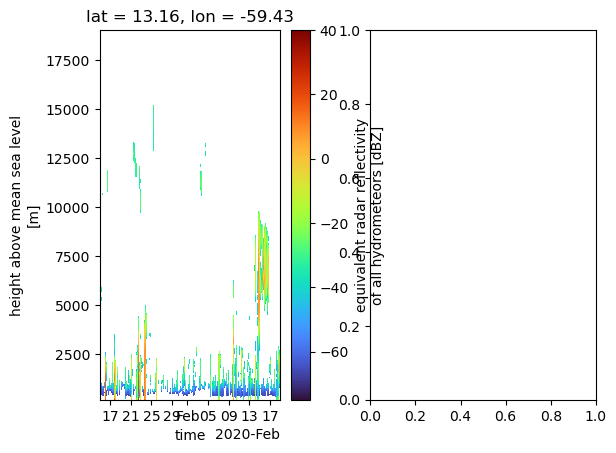

In [19]:
## --- have a look at radar

fig, ax = plt.subplots(1,2)

# EUREC4A
coral_radar.Ze.sel(time=slice('2020-01-15','2020-02-18')).resample(time="10min").mean().plot(ax=ax[0], x="time", y="alt", vmin=-75, vmax=40, cmap="turbo")

# ORCESTRA
coral_radar.Ze.sel(time=slice('2024-08-15','2024-09-23')).resample(time="10min").mean().plot(ax=ax[1], x="time", y="alt", vmin=-75, vmax=40, cmap="turbo")

